<a href="https://colab.research.google.com/github/itsmesaadali/Artificial-intelligence-Project/blob/main/AI_Lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI Lab 10

Write a Python program to implement the K-Means algorithm with different dataset and
updating different parameters. Also draw the proper graphs to graphically show the output of KNN
Algorithm

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Load your dataset
from google.colab import files
uploaded = files.upload()

# Read the CSV file
import io
file_name = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Display dataset information
print("Dataset Info:")
print(data.info())
print("\nDataset Head:")
print(data.head())
print(f"\nDataset Shape: {data.shape}")

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Saving clustering.csv to clustering.csv
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB
None

Dataset Head:
    Loan_ID Gender Married Dependents 

Gender encoded: {'Female': np.int64(0), 'Male': np.int64(1), 'nan': np.int64(2)}
Married encoded: {'No': np.int64(0), 'Yes': np.int64(1)}
Education encoded: {'Graduate': np.int64(0), 'Not Graduate': np.int64(1)}
Self_Employed encoded: {'No': np.int64(0), 'Yes': np.int64(1), 'nan': np.int64(2)}
Property_Area encoded: {'Rural': np.int64(0), 'Semiurban': np.int64(1), 'Urban': np.int64(2)}
Loan_Status encoded: {'N': np.int64(0), 'Y': np.int64(1)}
Dependents encoded: {'0': np.int64(0), '1': np.int64(1), '2': np.int64(2), '3+': np.int64(3), 'nan': np.int64(4)}

Features for Clustering:
   ApplicantIncome  LoanAmount  CoapplicantIncome  Credit_History
0         0.707469    0.812575           0.098695        0.458746
1        -0.408932   -1.376596          -0.546371        0.458746
2        -0.703019    0.530102           0.462294        0.458746
3         1.706799    1.271595          -0.546371        0.458746
4        -0.879330   -0.352629           0.102118        0.458746

Shape: (381, 4)


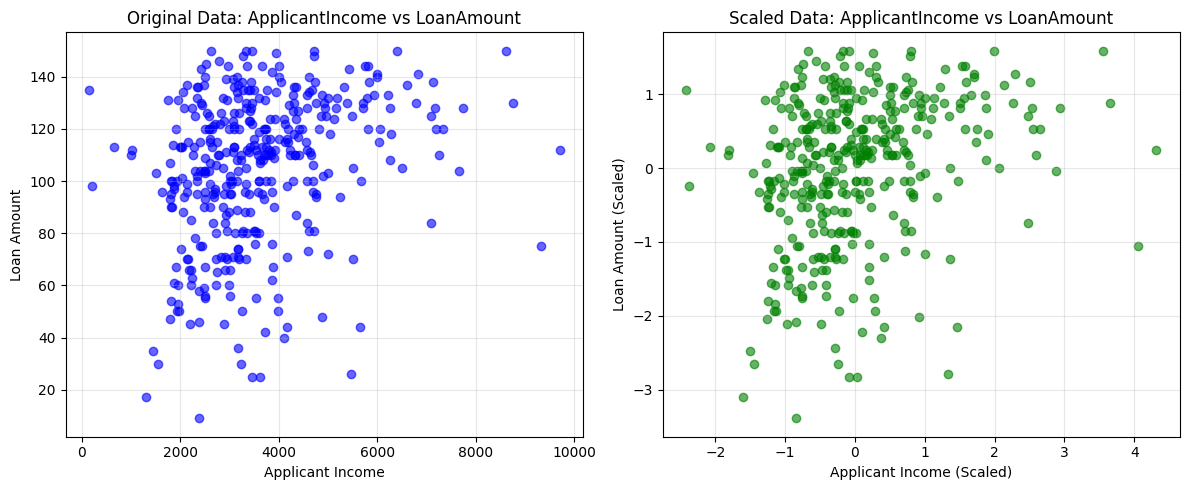

In [2]:
# Data Preprocessing for K-Means
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Create a copy of the data for clustering
clustering_data = data.copy()

# Handle categorical variables - convert to numeric
label_encoders = {}
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status', 'Dependents']

for col in categorical_columns:
    if col in clustering_data.columns:
        le = LabelEncoder()
        clustering_data[col] = le.fit_transform(clustering_data[col].astype(str))
        label_encoders[col] = le
        print(f"{col} encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Select numerical features for clustering (modify as needed)
# Using ApplicantIncome, LoanAmount, CoapplicantIncome as main features
features_for_clustering = ['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'Credit_History']

# Handle missing values by filling with mean/mode
for col in features_for_clustering:
    if clustering_data[col].isnull().any():
        if clustering_data[col].dtype in ['int64', 'float64']:
            clustering_data[col].fillna(clustering_data[col].mean(), inplace=True)
        else:
            clustering_data[col].fillna(clustering_data[col].mode()[0], inplace=True)

# Extract features for clustering
X = clustering_data[features_for_clustering].copy()

# Standardize the features (important for K-Means)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("\nFeatures for Clustering:")
print(X_scaled.head())
print(f"\nShape: {X_scaled.shape}")

# Visualize the original data points (first two features)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X['ApplicantIncome'], X['LoanAmount'], c='blue', alpha=0.6)
plt.title('Original Data: ApplicantIncome vs LoanAmount')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled['ApplicantIncome'], X_scaled['LoanAmount'], c='green', alpha=0.6)
plt.title('Scaled Data: ApplicantIncome vs LoanAmount')
plt.xlabel('Applicant Income (Scaled)')
plt.ylabel('Loan Amount (Scaled)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# K-Means Algorithm Implementation from Scratch

class KMeansCustom:
    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.clusters = None
        self.history = {'centroids': [], 'clusters': []}

    def initialize_centroids(self, X):
        """Step 1 & 2: Initialize random centroids"""
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        centroids = X.iloc[indices].copy()
        return centroids

    def euclidean_distance(self, point1, point2):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def assign_clusters(self, X, centroids):
        """Step 3: Assign points to closest centroids"""
        clusters = []
        for _, point in X.iterrows():
            distances = []
            for _, centroid in centroids.iterrows():
                dist = self.euclidean_distance(point, centroid)
                distances.append(dist)
            cluster = np.argmin(distances)
            clusters.append(cluster)
        return clusters

    def update_centroids(self, X, clusters):
        """Step 4: Update centroids based on cluster means"""
        new_centroids = []
        for i in range(self.k):
            cluster_indices = [j for j, c in enumerate(clusters) if c == i]
            if len(cluster_indices) > 0:
                cluster_points = X.iloc[cluster_indices]
                new_centroid = cluster_points.mean()
                new_centroids.append(new_centroid)
            else:
                # If cluster is empty, reinitialize randomly
                random_index = np.random.choice(X.shape[0])
                new_centroids.append(X.iloc[random_index])
        return pd.DataFrame(new_centroids, columns=X.columns)

    def fit(self, X):
        """Main K-Means algorithm"""
        # Initialize centroids
        self.centroids = self.initialize_centroids(X)
        print(f"Initial centroids initialized for k={self.k}")

        for iteration in range(self.max_iters):
            # Assign clusters
            clusters = self.assign_clusters(X, self.centroids)

            # Store history for visualization
            self.history['centroids'].append(self.centroids.copy())
            self.history['clusters'].append(clusters.copy())

            # Update centroids
            new_centroids = self.update_centroids(X, clusters)

            # Check for convergence
            centroid_change = np.sum(np.abs(new_centroids.values - self.centroids.values))

            if centroid_change < 1e-6:
                print(f"Converged after {iteration + 1} iterations")
                break

            self.centroids = new_centroids

            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}, Centroid change: {centroid_change:.6f}")

        self.clusters = clusters
        return self

    def predict(self, X):
        """Predict clusters for new data"""
        return self.assign_clusters(X, self.centroids)


K-Means with k=2
Initial centroids initialized for k=2
Iteration 10, Centroid change: 0.054049
Converged after 16 iterations


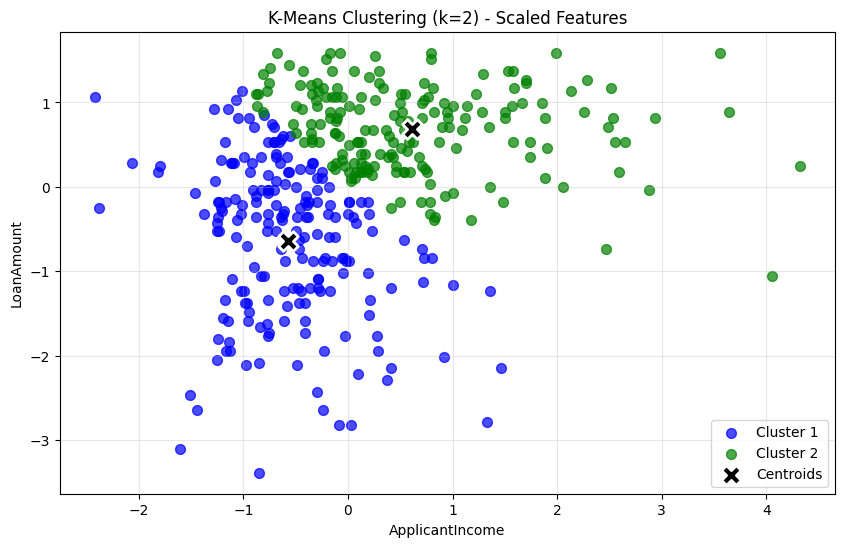

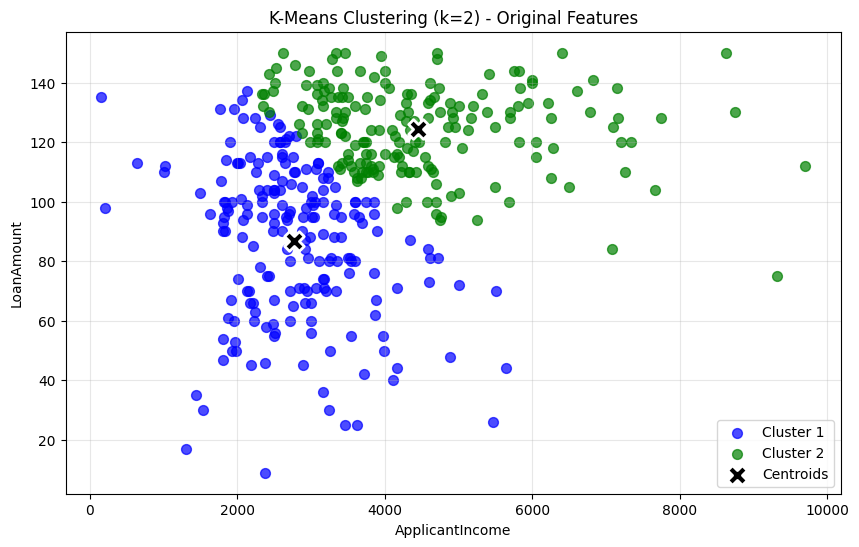

Inertia (Within-cluster sum of squares): 1216.55
Cluster sizes:
  Cluster 0: 197 customers
  Cluster 1: 184 customers

K-Means with k=3
Initial centroids initialized for k=3
Iteration 10, Centroid change: 0.123756
Converged after 11 iterations


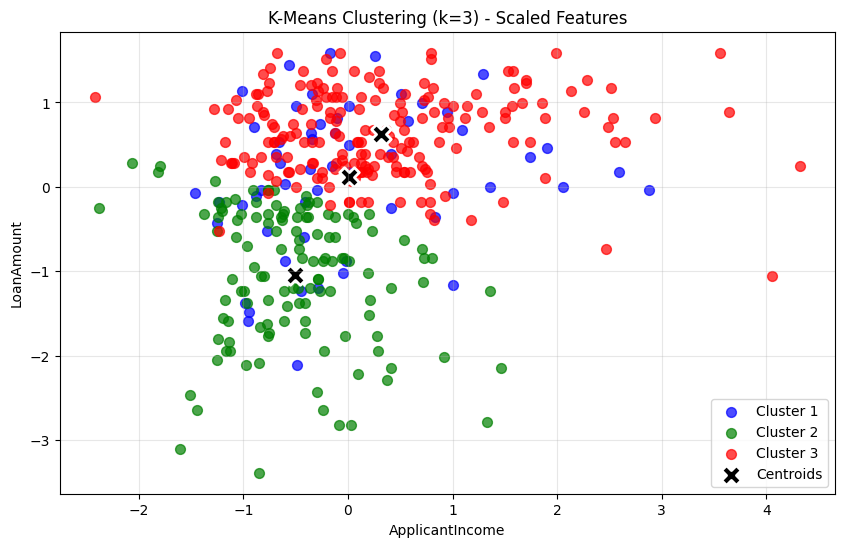

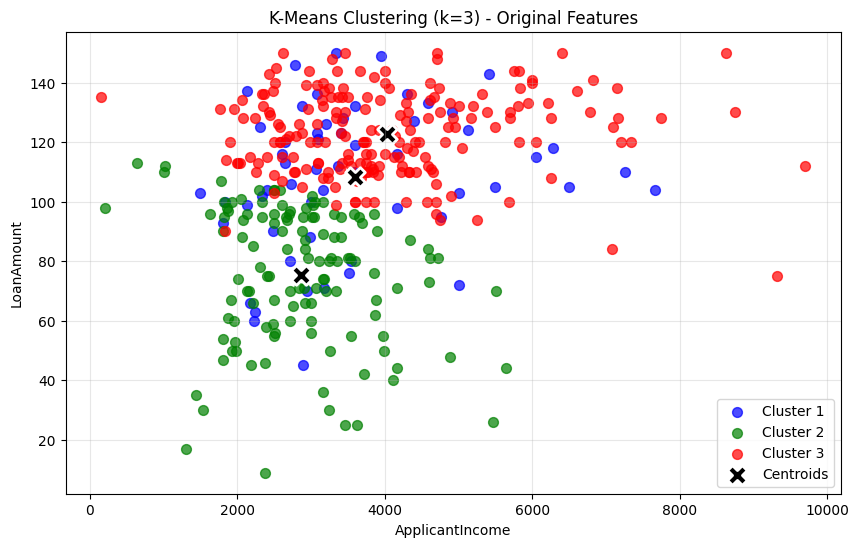

Inertia (Within-cluster sum of squares): 879.44
Cluster sizes:
  Cluster 0: 57 customers
  Cluster 1: 125 customers
  Cluster 2: 199 customers

K-Means with k=4
Initial centroids initialized for k=4
Iteration 10, Centroid change: 1.665383
Iteration 20, Centroid change: 0.118532
Converged after 21 iterations


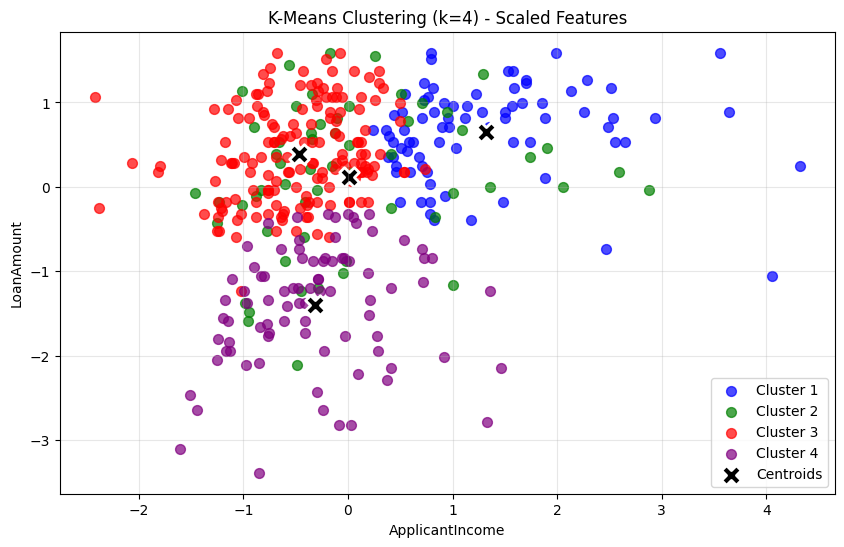

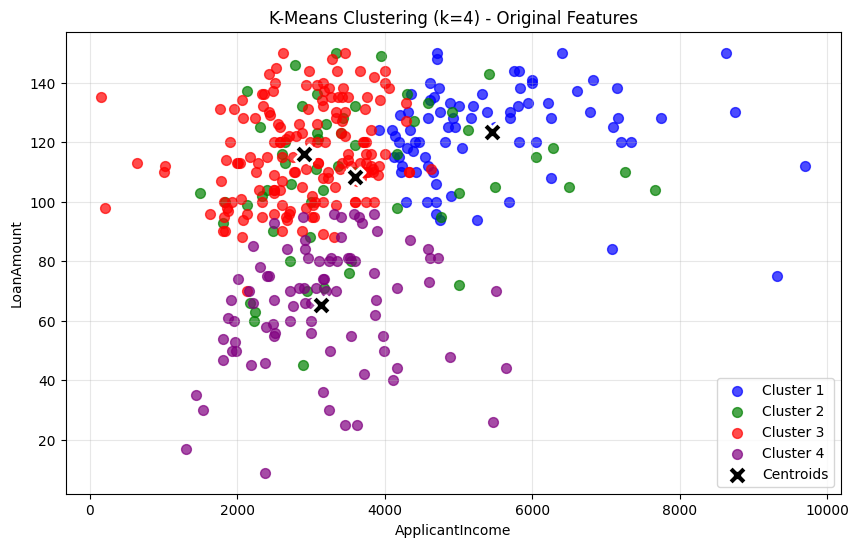

Inertia (Within-cluster sum of squares): 702.13
Cluster sizes:
  Cluster 0: 78 customers
  Cluster 1: 57 customers
  Cluster 2: 161 customers
  Cluster 3: 85 customers


In [6]:
# Implement K-Means with different parameters

def plot_clusters(X, centroids, clusters, k, title, feature1='ApplicantIncome', feature2='LoanAmount'):
    """Function to plot clusters and centroids"""
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i in range(k):
        cluster_points = X.iloc[[j for j, c in enumerate(clusters) if c == i]]
        plt.scatter(cluster_points[feature1], cluster_points[feature2],
                   c=colors[i % len(colors)], label=f'Cluster {i+1}', alpha=0.7, s=50)

    # Plot centroids
    plt.scatter(centroids[feature1], centroids[feature2],
               c='black', marker='X', s=200, label='Centroids', linewidths=2, edgecolors='white')

    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Test with different numbers of clusters
k_values = [2, 3, 4]

for k in k_values:
    print(f"\n{'='*60}")
    print(f"K-Means with k={k}")
    print(f"{'='*60}")

    # Initialize and fit K-Means
    kmeans = KMeansCustom(k=k, max_iters=100)
    kmeans.fit(X_scaled)

    # Plot final clusters (using scaled features)
    plot_clusters(X_scaled, kmeans.centroids, kmeans.clusters, k,
                 f'K-Means Clustering (k={k}) - Scaled Features')

    # Plot final clusters (using original features for interpretation)
    original_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.centroids),
                                    columns=X.columns)
    plot_clusters(X, original_centroids, kmeans.clusters, k,
                 f'K-Means Clustering (k={k}) - Original Features')

    # Calculate inertia (within-cluster sum of squares)
    inertia = 0
    for i in range(k):
        cluster_points = X_scaled.iloc[[j for j, c in enumerate(kmeans.clusters) if c == i]]
        if len(cluster_points) > 0:
            centroid = kmeans.centroids.iloc[i]
            distances = np.sum((cluster_points - centroid) ** 2).sum()
            inertia += distances

    print(f"Inertia (Within-cluster sum of squares): {inertia:.2f}")

    # Display cluster sizes
    cluster_sizes = pd.Series(kmeans.clusters).value_counts().sort_index()
    print("Cluster sizes:")
    for cluster_num, size in cluster_sizes.items():
        print(f"  Cluster {cluster_num}: {size} customers")

In [8]:
# Analyze cluster characteristics
def analyze_clusters(original_data, clusters, k, feature_names):
    """Analyze and display characteristics of each cluster"""
    cluster_data = original_data.copy()
    cluster_data['Cluster'] = clusters

    print("\nCluster Analysis:")
    print("="*50)

    for i in range(k):
        cluster_points = cluster_data[cluster_data['Cluster'] == i]
        print(f"\nCluster {i} (Size: {len(cluster_points)} customers):")
        print("-" * 30)

        # Display mean values for key features
        key_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History']
        for feature in key_features:
            if feature in cluster_points.columns:
                mean_val = cluster_points[feature].mean()
                print(f"  Average {feature}: {mean_val:.2f}")

        # Display categorical distribution for important features
        if 'Loan_Status' in cluster_points.columns:
            loan_status_dist = cluster_points['Loan_Status'].value_counts()
            print(f"  Loan Status Distribution: {dict(loan_status_dist)}")

        if 'Property_Area' in cluster_points.columns:
            # Since original_data is passed, 'Property_Area' already contains original string labels.
            # No need to inverse_transform, just get value counts directly.
            area_dist = cluster_points['Property_Area'].value_counts()
            print(f"  Property Area Distribution: {dict(area_dist)}")

# Analyze clusters for k=3 (you can change this)
k_final = 3
kmeans_final = KMeansCustom(k=k_final, max_iters=100)
kmeans_final.fit(X_scaled)

analyze_clusters(data, kmeans_final.clusters, k_final, X_scaled.columns)

Initial centroids initialized for k=3
Converged after 8 iterations

Cluster Analysis:

Cluster 0 (Size: 114 customers):
------------------------------
  Average ApplicantIncome: 3079.05
  Average CoapplicantIncome: 541.68
  Average LoanAmount: 70.54
  Average Credit_History: 0.89
  Loan Status Distribution: {'Y': np.int64(79), 'N': np.int64(35)}
  Property Area Distribution: {'Urban': np.int64(50), 'Semiurban': np.int64(41), 'Rural': np.int64(23)}

Cluster 1 (Size: 118 customers):
------------------------------
  Average ApplicantIncome: 5104.29
  Average CoapplicantIncome: 416.46
  Average LoanAmount: 120.79
  Average Credit_History: 0.85
  Loan Status Distribution: {'Y': np.int64(82), 'N': np.int64(36)}
  Property Area Distribution: {'Semiurban': np.int64(46), 'Urban': np.int64(37), 'Rural': np.int64(35)}

Cluster 2 (Size: 149 customers):
------------------------------
  Average ApplicantIncome: 2755.72
  Average CoapplicantIncome: 2521.80
  Average LoanAmount: 118.83
  Average Credi

Step-by-step K-Means Clustering Process (k=3)
Initial centroids initialized for k=3


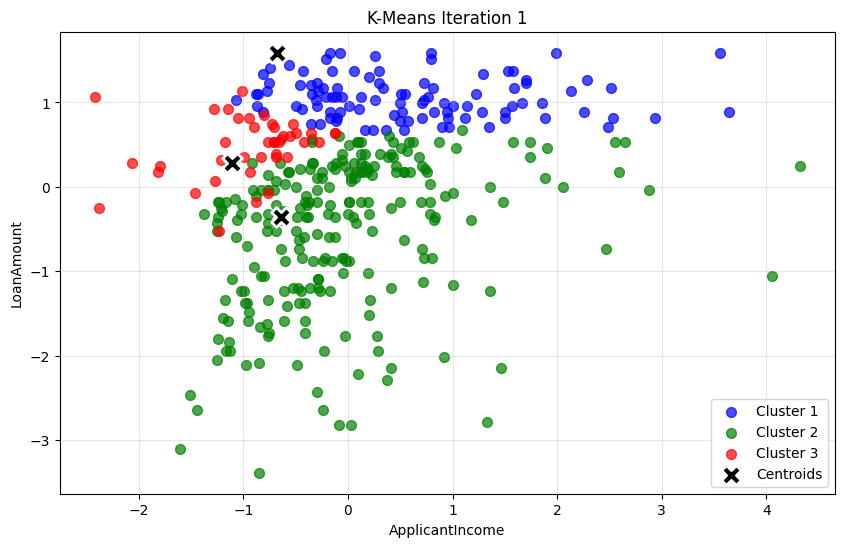

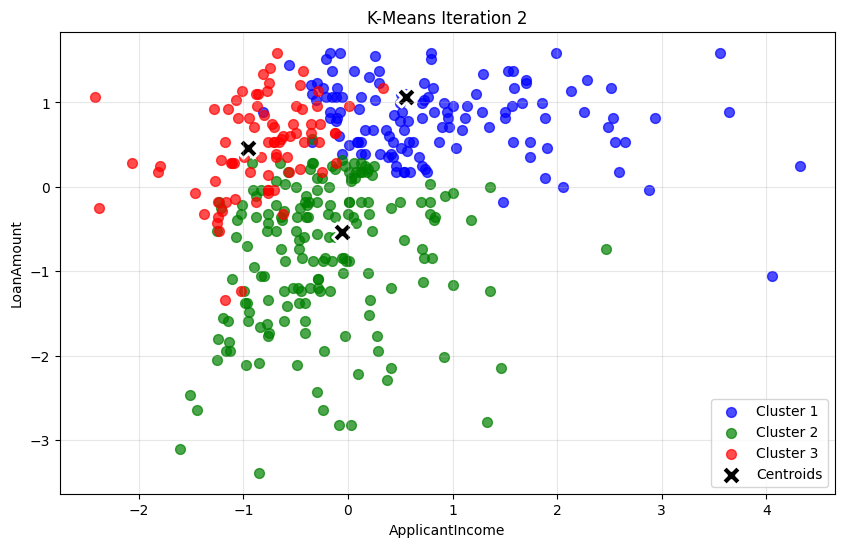

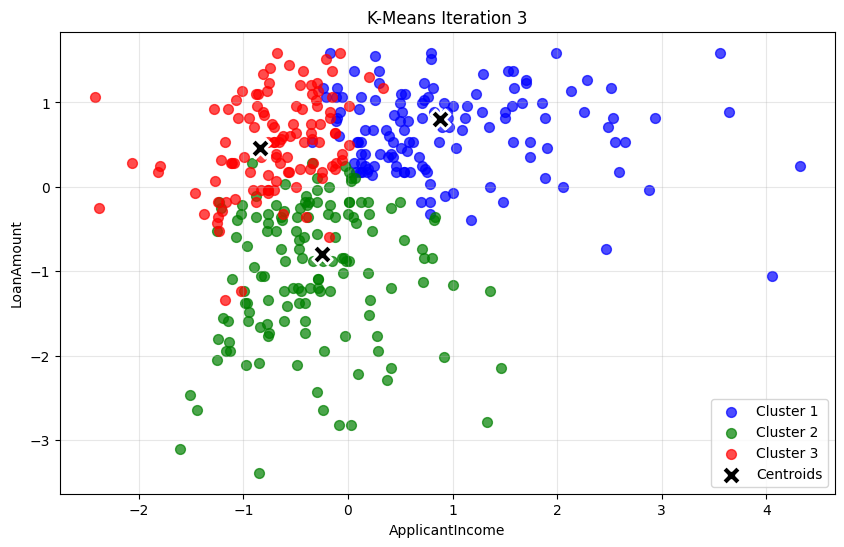

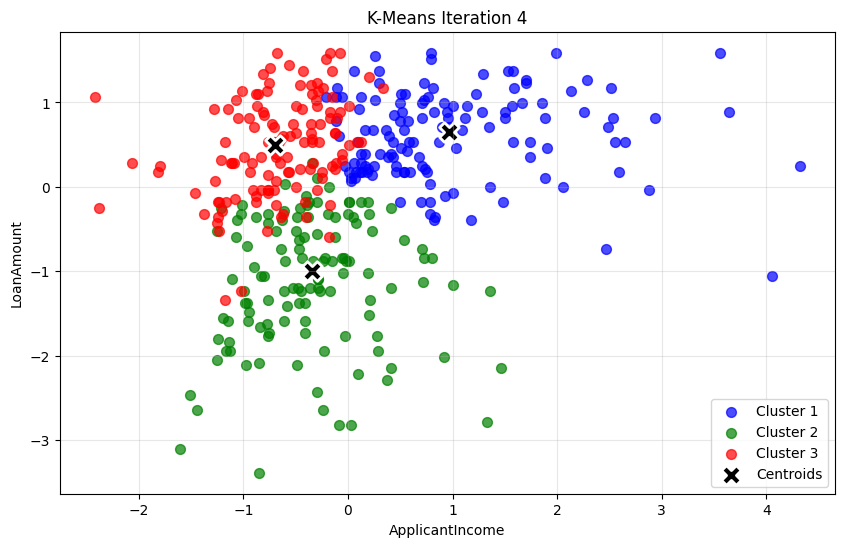

In [9]:
# Visualize the clustering process step by step
print("Step-by-step K-Means Clustering Process (k=3)")
print("="*60)

kmeans_process = KMeansCustom(k=3, max_iters=5)  # Fewer iterations for demonstration
kmeans_process.fit(X_scaled)

# Plot first few iterations
max_iterations_to_plot = min(4, len(kmeans_process.history['centroids']))
for i in range(max_iterations_to_plot):
    centroids = kmeans_process.history['centroids'][i]
    clusters = kmeans_process.history['clusters'][i]
    plot_clusters(X_scaled, centroids, clusters, 3, f'K-Means Iteration {i+1}')

Evaluation of Different K Values:
Initial centroids initialized for k=2
Converged after 2 iterations
k=2: Inertia = 1147.66, Dunn Index = 0.1993
Initial centroids initialized for k=3
Converged after 3 iterations
k=3: Inertia = 903.87, Dunn Index = 0.6404
Initial centroids initialized for k=4
Iteration 10, Centroid change: 0.155611
Iteration 20, Centroid change: 0.230117
Converged after 25 iterations
k=4: Inertia = 702.13, Dunn Index = 0.1419
Initial centroids initialized for k=5
Iteration 10, Centroid change: 0.109347
Converged after 17 iterations
k=5: Inertia = 589.34, Dunn Index = 0.4583
Initial centroids initialized for k=6
Iteration 10, Centroid change: 0.046936
Converged after 11 iterations
k=6: Inertia = 578.26, Dunn Index = 0.1011


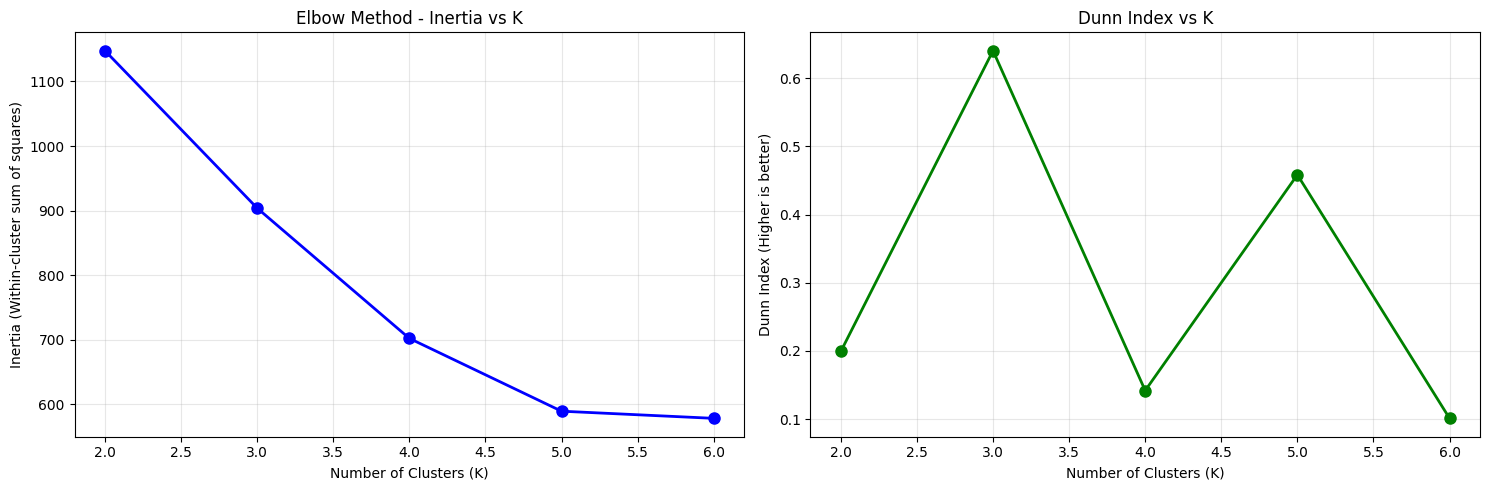


Optimal K Analysis:
Look for the 'elbow' in the inertia plot where the rate of decrease slows down
And higher Dunn Index values indicate better cluster separation


In [10]:
# Evaluation metrics and finding optimal K
def calculate_dunn_index(X, centroids, clusters, k):
    """Calculate Dunn Index to evaluate clustering quality"""

    # Calculate intra-cluster distances (maximum)
    max_intra_distance = 0
    for i in range(k):
        cluster_points = X.iloc[[j for j, c in enumerate(clusters) if c == i]]
        if len(cluster_points) > 0:
            centroid = centroids.iloc[i]
            distances = []
            for _, point in cluster_points.iterrows():
                dist = np.sqrt(np.sum((point - centroid) ** 2))
                distances.append(dist)
            cluster_max = max(distances) if distances else 0
            max_intra_distance = max(max_intra_distance, cluster_max)

    # Calculate inter-cluster distances (minimum)
    min_inter_distance = float('inf')
    for i in range(k):
        for j in range(i + 1, k):
            centroid_i = centroids.iloc[i]
            centroid_j = centroids.iloc[j]
            dist = np.sqrt(np.sum((centroid_i - centroid_j) ** 2))
            min_inter_distance = min(min_inter_distance, dist)

    # Dunn Index
    dunn_index = min_inter_distance / max_intra_distance if max_intra_distance > 0 else 0
    return dunn_index

# Evaluate different k values using Elbow Method
print("Evaluation of Different K Values:")
print("="*50)

k_results = []
for k in range(2, 7):
    kmeans_eval = KMeansCustom(k=k, max_iters=100)
    kmeans_eval.fit(X_scaled)

    # Calculate inertia
    inertia = 0
    for i in range(k):
        cluster_points = X_scaled.iloc[[j for j, c in enumerate(kmeans_eval.clusters) if c == i]]
        if len(cluster_points) > 0:
            centroid = kmeans_eval.centroids.iloc[i]
            distances = np.sum((cluster_points - centroid) ** 2).sum()
            inertia += distances

    # Calculate Dunn Index
    dunn_index = calculate_dunn_index(X_scaled, kmeans_eval.centroids, kmeans_eval.clusters, k)

    k_results.append({
        'k': k,
        'inertia': inertia,
        'dunn_index': dunn_index
    })

    print(f"k={k}: Inertia = {inertia:.2f}, Dunn Index = {dunn_index:.4f}")

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Inertia plot (Elbow Method)
inertia_values = [result['inertia'] for result in k_results]
k_values_eval = [result['k'] for result in k_results]
ax1.plot(k_values_eval, inertia_values, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Elbow Method - Inertia vs K')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.grid(True, alpha=0.3)

# Dunn Index plot
dunn_values = [result['dunn_index'] for result in k_results]
ax2.plot(k_values_eval, dunn_values, 'go-', linewidth=2, markersize=8)
ax2.set_title('Dunn Index vs K')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Dunn Index (Higher is better)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on elbow method and Dunn index
print("\nOptimal K Analysis:")
print("Look for the 'elbow' in the inertia plot where the rate of decrease slows down")
print("And higher Dunn Index values indicate better cluster separation")


Final K-Means Clustering with k=3
Initial centroids initialized for k=3
Iteration 10, Centroid change: 0.063769
Converged after 12 iterations


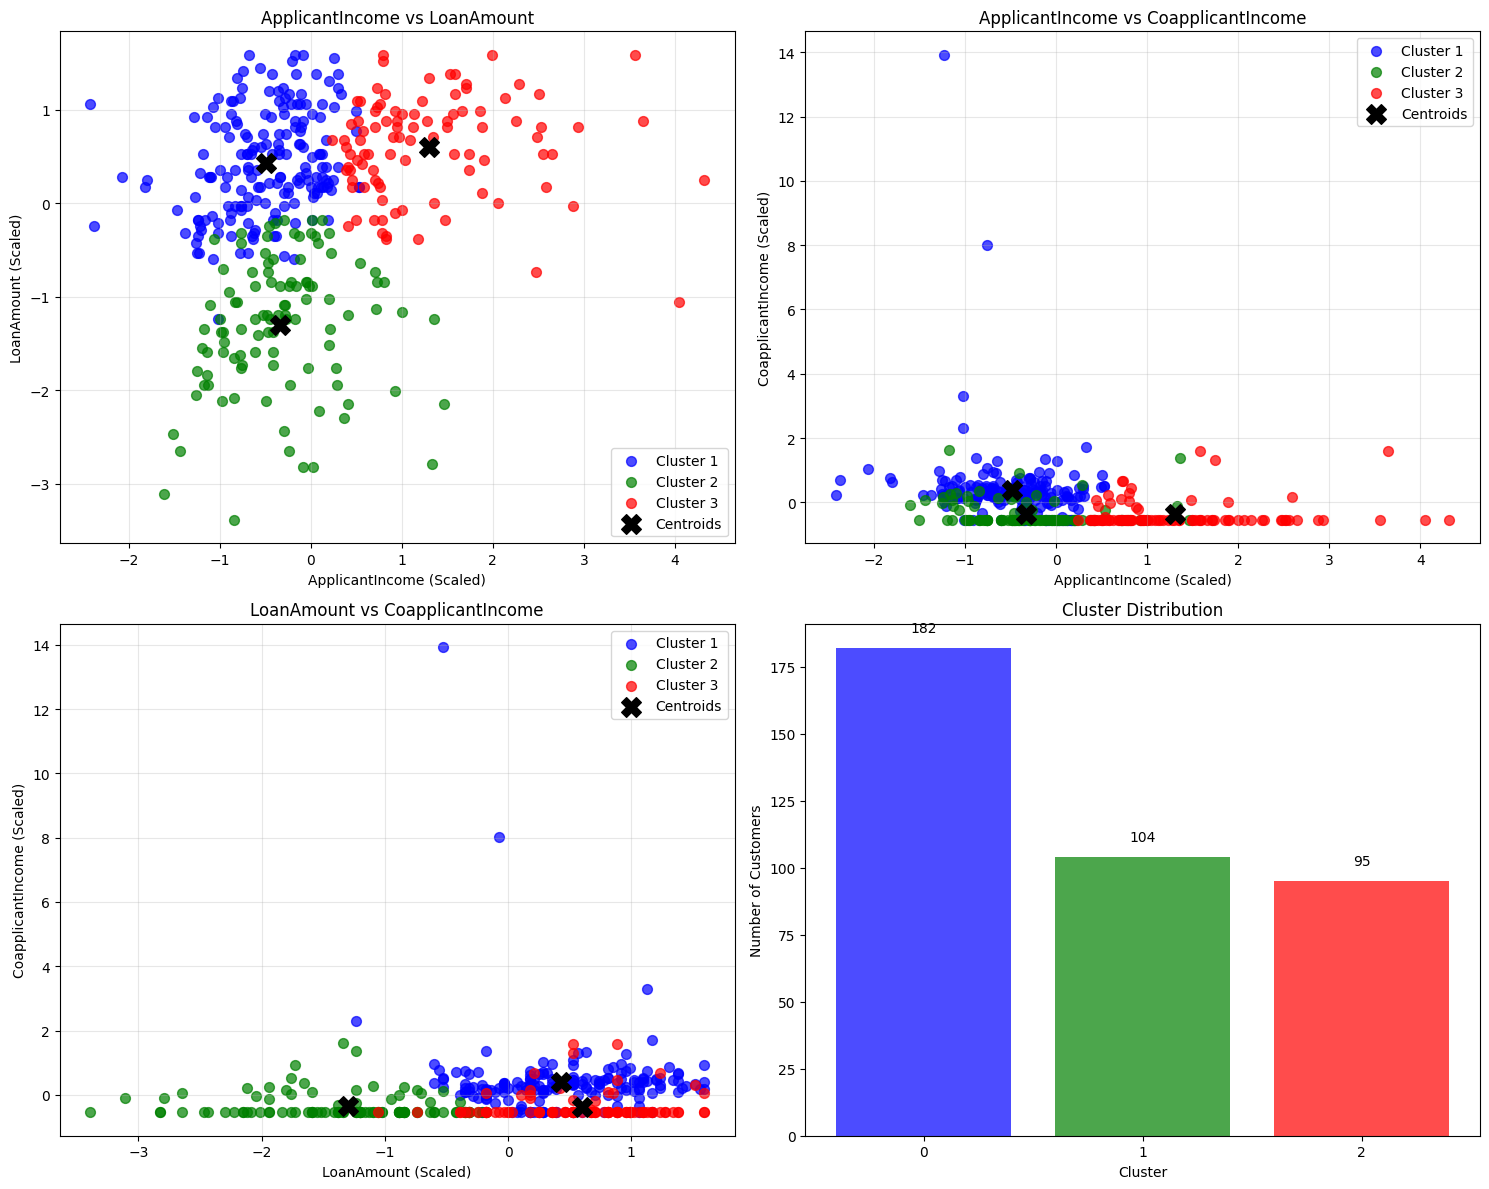


Final Cluster Characteristics:

Cluster Analysis:

Cluster 0 (Size: 182 customers):
------------------------------
  Average ApplicantIncome: 2884.87
  Average CoapplicantIncome: 2203.51
  Average LoanAmount: 117.13
  Average Credit_History: 0.82
  Loan Status Distribution: {'Y': np.int64(136), 'N': np.int64(46)}
  Property Area Distribution: {'Semiurban': np.int64(78), 'Rural': np.int64(53), 'Urban': np.int64(51)}

Cluster 1 (Size: 104 customers):
------------------------------
  Average ApplicantIncome: 3108.58
  Average CoapplicantIncome: 447.17
  Average LoanAmount: 68.19
  Average Credit_History: 0.88
  Loan Status Distribution: {'Y': np.int64(70), 'N': np.int64(34)}
  Property Area Distribution: {'Urban': np.int64(45), 'Semiurban': np.int64(37), 'Rural': np.int64(22)}

Cluster 2 (Size: 95 customers):
------------------------------
  Average ApplicantIncome: 5427.19
  Average CoapplicantIncome: 411.56
  Average LoanAmount: 122.00
  Average Credit_History: 0.82
  Loan Status Distr

In [11]:
# Final comprehensive visualization with optimal K
optimal_k = 3  # You can change this based on the elbow method results

print(f"\nFinal K-Means Clustering with k={optimal_k}")
print("="*50)

final_kmeans = KMeansCustom(k=optimal_k, max_iters=100)
final_kmeans.fit(X_scaled)

# Create subplots for comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: ApplicantIncome vs LoanAmount
colors = ['blue', 'green', 'red']
for i in range(optimal_k):
    cluster_points = X_scaled.iloc[[j for j, c in enumerate(final_kmeans.clusters) if c == i]]
    axes[0,0].scatter(cluster_points['ApplicantIncome'], cluster_points['LoanAmount'],
                     c=colors[i], label=f'Cluster {i+1}', alpha=0.7, s=50)
axes[0,0].scatter(final_kmeans.centroids['ApplicantIncome'], final_kmeans.centroids['LoanAmount'],
                 c='black', marker='X', s=200, label='Centroids')
axes[0,0].set_title('ApplicantIncome vs LoanAmount')
axes[0,0].set_xlabel('ApplicantIncome (Scaled)')
axes[0,0].set_ylabel('LoanAmount (Scaled)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: ApplicantIncome vs CoapplicantIncome
for i in range(optimal_k):
    cluster_points = X_scaled.iloc[[j for j, c in enumerate(final_kmeans.clusters) if c == i]]
    axes[0,1].scatter(cluster_points['ApplicantIncome'], cluster_points['CoapplicantIncome'],
                     c=colors[i], label=f'Cluster {i+1}', alpha=0.7, s=50)
axes[0,1].scatter(final_kmeans.centroids['ApplicantIncome'], final_kmeans.centroids['CoapplicantIncome'],
                 c='black', marker='X', s=200, label='Centroids')
axes[0,1].set_title('ApplicantIncome vs CoapplicantIncome')
axes[0,1].set_xlabel('ApplicantIncome (Scaled)')
axes[0,1].set_ylabel('CoapplicantIncome (Scaled)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: LoanAmount vs CoapplicantIncome
for i in range(optimal_k):
    cluster_points = X_scaled.iloc[[j for j, c in enumerate(final_kmeans.clusters) if c == i]]
    axes[1,0].scatter(cluster_points['LoanAmount'], cluster_points['CoapplicantIncome'],
                     c=colors[i], label=f'Cluster {i+1}', alpha=0.7, s=50)
axes[1,0].scatter(final_kmeans.centroids['LoanAmount'], final_kmeans.centroids['CoapplicantIncome'],
                 c='black', marker='X', s=200, label='Centroids')
axes[1,0].set_title('LoanAmount vs CoapplicantIncome')
axes[1,0].set_xlabel('LoanAmount (Scaled)')
axes[1,0].set_ylabel('CoapplicantIncome (Scaled)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Cluster distribution
cluster_counts = pd.Series(final_kmeans.clusters).value_counts().sort_index()
axes[1,1].bar(cluster_counts.index, cluster_counts.values, color=colors[:optimal_k], alpha=0.7)
axes[1,1].set_title('Cluster Distribution')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_xticks(range(optimal_k))
for i, count in enumerate(cluster_counts.values):
    axes[1,1].text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final cluster analysis
print("\nFinal Cluster Characteristics:")
analyze_clusters(data, final_kmeans.clusters, optimal_k, X_scaled.columns)

# Add clusters to original data for further analysis
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = final_kmeans.clusters
print(f"\nDataset with clusters added. First 10 rows:")
print(data_with_clusters[['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'Credit_History', 'Cluster']].head(10))